In [1]:
import numpy as np

import sys
import os

os.environ['TOOLBOX_PATH'] = "/PATH/TO/BART/"
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python/")
sys.path.append("PATH/TO/TOOLS/")

import struct
import cfl

from copy import deepcopy

from matplotlib import pyplot as plt
from matplotlib import lines as lines
from matplotlib import colors as col
from matplotlib import patches as patches
%matplotlib inline

import toolbox as tools

import pickle5 as pickle
import skimage
import nibabel as nib

In [2]:
load_folder = 'Saved_Recon_Data/Regularization_Results/'
gif_folder = 'final_gifs/'
figure_folder = 'Saved_Figures/'

In [6]:
#load TV

TV_params = [0.00001,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1,1,10]

path = 'reg_BFFE_cv1_TV_'

TV_data = []
TV_diff_median = []

for reg_param in TV_params:

    str(reg_param).replace('.','_')
    with open(load_folder+path+str(reg_param).replace('.','_')+'.pickle', 'rb') as handle:
        TV_data.append(pickle.load(handle))
    TV_diff_median.append(tools.random.im_complex_median(TV_data[-1]['diff'],filter_size_time=3))

In [7]:
#load TGV

TGV_params = [0.00001,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1,1,10]
path = 'reg_BFFE_cv1_TGV_'

TGV_data = []
TGV_diff_median = []

for reg_param in TGV_params:

    str(reg_param).replace('.','_')
    with open(load_folder+path+str(reg_param).replace('.','_')+'.pickle', 'rb') as handle:
        TGV_data.append(pickle.load(handle))
    TGV_diff_median.append(tools.random.im_complex_median(TGV_data[-1]['diff'],filter_size_time=3))

In [8]:
# load TGV FB

TGV_FB_params = [0.00001,0.0001,0.001,0.002,0.005,0.01,0.02,0.05,0.1]

path = 'reg_BFFE_cv1_FB_TGV_'

TGV_FB_data = []

for reg_param in TGV_FB_params:

    str(reg_param).replace('.','_')
    with open(load_folder+path+str(reg_param).replace('.','_')+'.pickle', 'rb') as handle:
        TGV_FB_data.append(pickle.load(handle))

In [9]:
#load LLR

LLR_params = [0.00001,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1,1,10]

path = 'reg_BFFE_cv1_LLR_'

LLR_data = []
LLR_diff_median = []

for reg_param in LLR_params:

    str(reg_param).replace('.','_')
    with open(load_folder+path+str(reg_param).replace('.','_')+'.pickle', 'rb') as handle:
        LLR_data.append(pickle.load(handle))
    LLR_diff_median.append(tools.random.im_complex_median(LLR_data[-1]['diff'],filter_size_time=3))

In [10]:
#load L2

L2_params = [0.00001,0.0001,0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,10]

path = 'reg_BFFE_cv1_L2_'

L2_data = []
L2_diff_median = []

for reg_param in L2_params:

    str(reg_param).replace('.','_')
    with open(load_folder+path+str(reg_param).replace('.','_')+'.pickle', 'rb') as handle:
        L2_data.append(pickle.load(handle))
    L2_diff_median.append(tools.random.im_complex_median(L2_data[-1]['diff'],filter_size_time=3))
# Load L2=0 Reference

with open(load_folder+path+str(0).replace('.','_')+'.pickle', 'rb') as handle:
    L2_ref = pickle.load(handle)


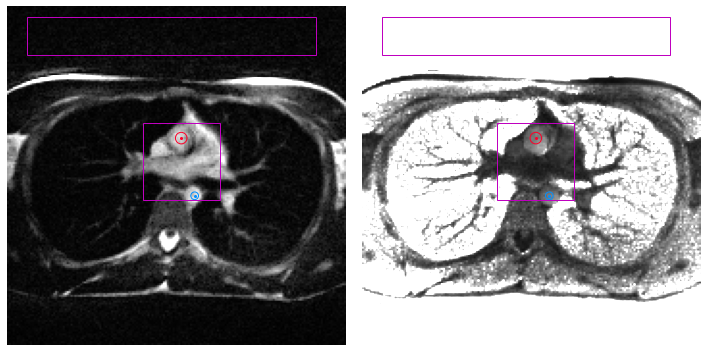

In [11]:
probe_indices = [[68,90],[98,97]]
roi_radius = [3,2]

std_probe_indices = [[10,5],[70,60]]
std_roi_size = [[150,20],[40,40]]

ref_mag = np.squeeze(np.min(np.abs(L2_ref['result0']),axis=2))
ref_phase = np.squeeze(np.max(np.angle(L2_ref['result0']),axis=2)) - np.squeeze(np.min(np.angle(L2_ref['result0']),axis=2))
plt.close('all')
f, a = plt.subplots(1, 2, figsize=(10, 5))

a[0].imshow(ref_mag,cmap='gray',vmin=0,vmax = np.percentile(ref_mag,99))
a[1].imshow(ref_phase,cmap = 'gray',vmin = 0,vmax = np.pi)

masks = []

for index, radius, idx in zip(probe_indices, roi_radius,range(len(probe_indices))):
    
    cm = plt.cm.gist_rainbow(idx/(len(probe_indices)-0.5))
    a[0].plot(index[1],index[0],marker="o",markerfacecolor=cm,markeredgecolor=cm,markersize=2)
    a[1].plot(index[1],index[0],marker="o",markerfacecolor=cm,markeredgecolor=cm,markersize=2)
    
    circle1 = plt.Circle((index[1], index[0]), radius , ec=cm, fill=False)
    circle2 = plt.Circle((index[1], index[0]), radius , ec=cm, fill=False)
    a[0].add_patch(circle1)
    a[1].add_patch(circle2)
    
    mask = np.zeros_like(ref_mag)
    mask[index[0],index[1]] = 1
    d = skimage.morphology.disk(radius)
    mask = skimage.morphology.binary_dilation(mask,d)
    
    masks.append(mask)

std_masks = []
    
for index, size, idx in zip(std_probe_indices, std_roi_size,range(len(std_probe_indices))):
    

    rect = plt.Rectangle(index,size[0],size[1],fill=False,ec='m')
    a[0].add_patch(rect)
    rect = plt.Rectangle(index,size[0],size[1],fill=False,ec='m')
    a[1].add_patch(rect)
    
    mask = np.zeros_like(ref_mag)
    mask[index[1]:(index[1]+size[1]),index[0]:(index[0]+size[0])] = 1
    
    std_masks.append(mask)
    
[_.axis("off") for _ in a.flatten()];
f.tight_layout()


# just for checking masks
# f, a = plt.subplots(1, 2, figsize=(6, 3))

# total_mask = np.ones_like(ref_mag)

# for mask in masks:
#     total_mask = total_mask * ~mask
    
# a[0].imshow(total_mask*ref_mag,cmap='gray',vmin=0,vmax = np.percentile(ref_mag,99))
# a[1].imshow(total_mask*ref_phase,cmap = 'gray',vmin = 0,vmax = np.pi)

# [_.axis("off") for _ in a.flatten()];
# f.tight_layout()

In [12]:
field = 'diff'

# Calculate L2 reference statistics

mean_L2_ref = []
std_L2_ref = []
mean_L2_med_ref = []

data = np.angle(np.squeeze(L2_ref[field]))
data_m = np.squeeze(np.angle(tools.random.im_complex_median(L2_ref[field],filter_size_time=3)))
for mask in masks:
        
    sub = data*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
    sub[sub==0] = np.nan

    mean_L2_ref.append(np.nanmean(sub,axis=(0,1)))
    std_L2_ref.append(np.nanstd(sub,axis=(0,1)))
    
    sub = data_m*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
    sub[sub==0] = np.nan
    mean_L2_med_ref.append(np.nanmean(sub,axis=(0,1)))

# Calculate TV statistics
    
TV_mean_list = []
TV_std_list = []
TV_median_mean_list = []

for data_dict in TV_data:
    
    data = np.angle(np.squeeze(data_dict[field]))
    data_m = np.squeeze(np.angle(tools.random.im_complex_median(data_dict[field],filter_size_time=3)))
    
    ml = []
    sl = []
    mml = []
    
    for mask in masks:
        
        sub = data*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        m = np.nanmean(sub,axis=(0,1))
        s = np.nanstd(sub,axis=(0,1))
        
        ml.append(m)
        sl.append(s)
        
        sub = data_m*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        m = np.nanmean(sub,axis=(0,1))
        
        mml.append(m)
        
        
    TV_mean_list.append(ml)
    TV_std_list.append(sl)
    TV_median_mean_list.append(mml)
    
# Calculate TGV statistics
    
TGV_mean_list = []
TGV_std_list = []
TGV_median_mean_list = []

for data_dict in TGV_data:
    
    data = np.angle(np.squeeze(data_dict[field]))
    data_m = np.squeeze(np.angle(tools.random.im_complex_median(data_dict[field],filter_size_time=3)))
    
    ml = []
    sl = []
    mml = []
    
    for mask in masks:
        
        sub = data*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        m = np.nanmean(sub,axis=(0,1))
        s = np.nanstd(sub,axis=(0,1))
        
        ml.append(m)
        sl.append(s)
        
        sub = data_m*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        m = np.nanmean(sub,axis=(0,1))
        
        mml.append(m)
    TGV_mean_list.append(ml)
    TGV_std_list.append(sl)
    TGV_median_mean_list.append(mml)
    
# Calculate TGV FB statistics

resp_phase = 3
    
TGV_FB_mean_list = []
TGV_FB_std_list = []

for data_dict in TGV_FB_data:
    
    data = np.angle(np.squeeze(data_dict[field][:,:,:,resp_phase]))
    
    ml = []
    sl = []
    
    for mask in masks:
        
        sub = data*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        m = np.nanmean(sub,axis=(0,1))
        s = np.nanstd(sub,axis=(0,1))
        
        ml.append(m)
        sl.append(s)
    TGV_FB_mean_list.append(ml)
    TGV_FB_std_list.append(sl)
    
# Calculate LLR statistics
    
LLR_mean_list = []
LLR_std_list = []
LLR_median_mean_list = []

for data_dict in LLR_data:
    
    data = np.angle(np.squeeze(data_dict[field]))
    data_m = np.squeeze(np.angle(tools.random.im_complex_median(data_dict[field],filter_size_time=3)))
    
    ml = []
    sl = []
    mml = []
    
    for mask in masks:
        
        sub = data*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        m = np.nanmean(sub,axis=(0,1))
        s = np.nanstd(sub,axis=(0,1))
        
        ml.append(m)
        sl.append(s)
        
        sub = data_m*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        m = np.nanmean(sub,axis=(0,1))
        
        mml.append(m)
    LLR_mean_list.append(ml)
    LLR_std_list.append(sl)
    LLR_median_mean_list.append(mml)

# Calculate L2 statistics
    
L2_mean_list = []
L2_std_list = []
L2_median_mean_list = []

for data_dict in L2_data:
    
    data = np.angle(np.squeeze(data_dict[field]))
    data_m = np.squeeze(np.angle(tools.random.im_complex_median(data_dict[field],filter_size_time=3)))
    
    ml = []
    sl = []
    mml = []
    
    for mask in masks:
        
        sub = data*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        m = np.nanmean(sub,axis=(0,1))
        s = np.nanstd(sub,axis=(0,1))
        
        ml.append(m)
        sl.append(s)
        
        sub = data_m*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        m = np.nanmean(sub,axis=(0,1))
        
        mml.append(m)
    L2_mean_list.append(ml)
    L2_std_list.append(sl)
    L2_median_mean_list.append(mml)
    
    
    

In [13]:
field = 'diff'

# Calculate Magnitude statistics

# Calculate L2 reference statistics

mag_std_L2_ref = []
mag_std_L2_median_ref = []

data = np.abs(np.squeeze(L2_ref[field]))
data_m = tools.random.im_complex_median(data,filter_size_time=3)
for mask in std_masks:
        
    sub = data*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
    sub[sub==0] = np.nan

    mag_std_L2_ref.append(np.nanmean(np.nanstd(sub,axis=2),axis=(0,1)))
    
    sub = data_m*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
    sub[sub==0] = np.nan

    mag_std_L2_median_ref.append(np.nanmean(np.nanstd(sub,axis=2),axis=(0,1)))


# Calculate TV statistics
    
mag_std_TV = []
mag_median_std_TV = []

for data_dict in TV_data:
    
    sl = []
    sl_m = []
    
    data = np.abs(np.squeeze(data_dict[field]))
    data_m = tools.random.im_complex_median(data,filter_size_time=3)
    
    for mask in std_masks:
        
        sub = data*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        s = np.nanmean(np.nanstd(sub,axis=2),axis=(0,1))        
        sl.append(s)
        
        sub = data_m*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        s = np.nanmean(np.nanstd(sub,axis=2),axis=(0,1))        
        sl_m.append(s)
        
    mag_std_TV.append(sl)
    mag_median_std_TV.append(sl_m)
    
# Calculate TGV statistics
    
mag_std_TGV = []
mag_median_std_TGV = []

for data_dict in TGV_data:
    
    sl = []
    sl_m = []
    
    data = np.abs(np.squeeze(data_dict[field]))
    data_m = tools.random.im_complex_median(data,filter_size_time=3)
    for mask in std_masks:
        
        sub = data*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        s = np.nanmean(np.nanstd(sub,axis=2),axis=(0,1))        
        sl.append(s)
        
        sub = data_m*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        s = np.nanmean(np.nanstd(sub,axis=2),axis=(0,1))        
        sl_m.append(s)
        
    mag_std_TGV.append(sl)
    mag_median_std_TGV.append(sl_m)
    
# Calculate LLR statistics
    
mag_std_LLR = []
mag_median_std_LLR = []

for data_dict in LLR_data:
    
    sl = []
    sl_m = []
    
    data = np.abs(np.squeeze(data_dict[field]))
    data_m = tools.random.im_complex_median(data,filter_size_time=3)
    for mask in std_masks:
        
        sub = data*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        s = np.nanmean(np.nanstd(sub,axis=2),axis=(0,1))        
        sl.append(s)
        
        sub = data_m*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        s = np.nanmean(np.nanstd(sub,axis=2),axis=(0,1))        
        sl_m.append(s)
        
    mag_std_LLR.append(sl)
    mag_median_std_LLR.append(sl_m)

# Calculate L2 statistics
    
mag_std_L2 = []
mag_median_std_L2 = []

for data_dict in L2_data:
    
    sl = []
    sl_m = []
    
    data = np.abs(np.squeeze(data_dict[field]))
    data_m = tools.random.im_complex_median(data,filter_size_time=3)
    for mask in std_masks:
        
        sub = data*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        s = np.nanmean(np.nanstd(sub,axis=2),axis=(0,1))        
        sl.append(s)
        
        sub = data_m*np.repeat(mask[...,np.newaxis],data.shape[2],axis=2)
        sub[sub==0] = np.nan
        
        s = np.nanmean(np.nanstd(sub,axis=2),axis=(0,1))        
        sl_m.append(s)
        
    mag_std_L2.append(sl)
    mag_median_std_L2.append(sl_m)
        

In [14]:
# f, a = plt.subplots(1, len(probe_indices), figsize=(10, 5))

# for mean_data, idx in zip(TV_mean_list,range(len(TV_mean_list))):
    
#     cm = plt.cm.viridis(idx/(5*len(mean_list)))
#     for a_idx in range(len(probe_indices)):
#         if isinstance(a, np.ndarray):
#             a[a_idx].plot(mean_data[a_idx],color=cm)
#         else:
#             a.plot(mean_data[a_idx],color=cm)
            
# for mean_data, idx in zip(L2_mean_list,range(len(L2_mean_list))):
    
#     cm = plt.cm.viridis((idx+3*len(mean_list))/(5*len(mean_list)))
#     for a_idx in range(len(probe_indices)):
#         if isinstance(a, np.ndarray):
#             a[a_idx].plot(mean_data[a_idx],color=cm)
#         else:
#             a.plot(mean_data[a_idx],color=cm)

In [15]:
peak_index = [17,18,19]

colors = ['royalblue','darkorange','forestgreen','firebrick']

TV_mean_data = np.asarray(TV_mean_list)
TV_median_mean_data = np.asarray(TV_median_mean_list)
TV_std_data = np.asarray(TV_std_list)

TGV_mean_data = np.asarray(TGV_mean_list)
TGV_median_mean_data = np.asarray(TGV_median_mean_list)
TGV_std_data = np.asarray(TGV_std_list)

LLR_mean_data = np.asarray(LLR_mean_list)
LLR_median_mean_data = np.asarray(LLR_median_mean_list)
LLR_std_data = np.asarray(LLR_std_list)

L2_mean_data = np.asarray(L2_mean_list)
L2_median_mean_data = np.asarray(L2_median_mean_list)
L2_std_data = np.asarray(L2_std_list)

plt.close('all')
f, a = plt.subplots(1, len(probe_indices), figsize=(10, 5))

for a_idx in range(len(probe_indices)):
    if isinstance(a, np.ndarray):
        a[a_idx].semilogx(L2_params,L2_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[2])
        a[a_idx].semilogx(TV_params,TV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[0])
        a[a_idx].semilogx(TGV_params,TGV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[1])
        a[a_idx].semilogx(LLR_params,LLR_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[3])
        
        a[a_idx].semilogx(L2_params,L2_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[2],linestyle='--')
        a[a_idx].semilogx(TV_params,TV_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[0],linestyle='--')
        a[a_idx].semilogx(TGV_params,TGV_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[1],linestyle='--')
        a[a_idx].semilogx(LLR_params,LLR_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[3],linestyle='--')
    else:
        a.semilogx(L2_params,L2_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]])
        a.semilogx(TV_params,TV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]])
        a.semilogx(TGV_params,TGV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]])
        a.semilogx(LLR_params,LLR_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]])
        

custom_lines = [lines.Line2D([0], [0], color=colors[2], lw=1),
                lines.Line2D([0], [0], color=colors[0], lw=1),
                lines.Line2D([0], [0], color=colors[1], lw=1),
                lines.Line2D([0], [0], color=colors[3], lw=1),
                lines.Line2D([0], [0], color=[0.4,0.4,0.4], lw=1, linestyle='--')]        
a[0].legend(custom_lines,['$\mathregular{L2_x}$','$\mathregular{TV_t}$','$\mathregular{TGV_t}$','$\mathregular{LLR_t}$','$\mathregular{+ Median_t}$'],loc=1)

a[0].set_ylim([0.8,1.01])
a[1].set_ylim([0.8,1.01])

a[0].set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])
a[1].set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])

a[0].set_ylabel('Peak Velocity Relative to Unregularized')

a[0].set_xlabel('Regularization Parameter α')
a[1].set_xlabel('Regularization Parameter α')

a[0].set_title('Ascending Aorta')
a[1].set_title('Desending Aorta')

a[1].set_yticklabels([])

a[0].grid()
a[1].grid()

f.tight_layout()

In [16]:
peak_index = [17,18,19]

TGV_mean_data = np.asarray(TGV_mean_list)
TGV_std_data = np.asarray(TGV_std_list)

TGV_FB_mean_data = np.asarray(TGV_FB_mean_list)
TGV_FB_std_data = np.asarray(TGV_FB_std_list)


plt.close('all')
f, a = plt.subplots(1, len(probe_indices), figsize=(10, 5))

for a_idx in range(len(probe_indices)):
    if isinstance(a, np.ndarray):
        #a[a_idx].semilogx(TGV_params,TGV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]])
        #a[a_idx].semilogx(TGV_FB_params,TGV_FB_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]])
        
        a[a_idx].semilogx(TGV_params,TGV_mean_data[:,a_idx,peak_index[a_idx]]/TGV_mean_data[0,a_idx,peak_index[a_idx]])
        a[a_idx].semilogx(TGV_FB_params,TGV_FB_mean_data[:,a_idx,peak_index[a_idx]]/TGV_FB_mean_data[0,a_idx,peak_index[a_idx]])
    else:
        a.semilogx(TGV_params,TGV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]])
        a.semilogx(TGV_FB_params,TGV_FB_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]])
        
a[0].legend(['TGV BH','TGV FB'])

a[0].set_ylim([0.8,1.01])
a[1].set_ylim([0.8,1.01])

a[0].set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])
a[1].set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])

a[0].set_ylabel('Peak Velocity Relative to Unregularized')

a[0].set_xlabel('Regularization Parameter α')
a[1].set_xlabel('Regularization Parameter α')

a[0].set_title('Ascending Aorta')
a[1].set_title('Descending Aorta')

a[1].set_yticklabels([])

a[0].grid()
a[1].grid()

f.tight_layout()

In [17]:
# 0.01 - 5-7% error in peak flow, but very bad magnitude. Some other errors in low flow, hard to say what is correct
# 0.001 - Very small error from lower regularized, <4% error from L2 reference. Magnitude is stll a little flashy, but no noticable motion problems
# Note that introducing 3 wide median filter will cause at least 10% underestimation...but should be tested

In [18]:
# Order L2, TV, TGV, LLR
alpha_opt = [0.1, 0.01,0.01,0.01]

ref_im = L2_ref['diff']
ind_L2 = np.where(np.asarray(L2_params) == alpha_opt[0])[0][0]
ind_TV = np.where(np.asarray(TV_params) == alpha_opt[1])[0][0]
ind_TGV = np.where(np.asarray(TGV_params) == alpha_opt[2])[0][0]
ind_LLR = np.where(np.asarray(LLR_params) == alpha_opt[3])[0][0]

In [19]:
images = [ref_im,L2_data[ind_L2]['diff'],TV_data[ind_TV]['diff'],TGV_data[ind_TGV]['diff'],LLR_data[ind_LLR]['diff']]
images = np.stack(images,axis=4)

In [20]:
#gif = tools.visualization.save_to_gif('best_reg.gif',images[:,:,:,0,:],cmap_mag='gray',cmap_phase='bgr',magthresh=98)

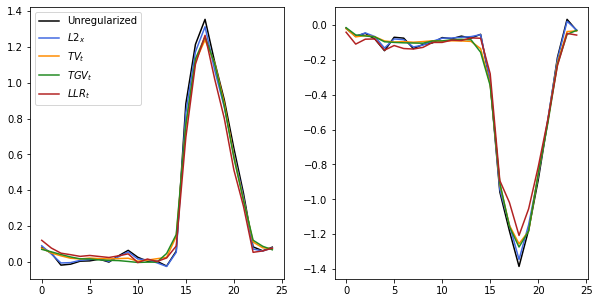

In [21]:
f, a = plt.subplots(1, len(probe_indices), figsize=(10, 5))

for idx in range(len(probe_indices)):

    a[idx].plot(mean_L2_ref[idx],'k')
    a[idx].plot(L2_mean_list[ind_L2][idx],colors[0])
    a[idx].plot(TV_mean_list[ind_TV][idx],colors[1])
    a[idx].plot(TGV_mean_list[ind_TGV][idx],colors[2])
    a[idx].plot(LLR_mean_list[ind_LLR][idx],colors[3])

a[0].legend(['Unregularized','$L2_{x}$','$TV_{t}$','$TGV_{t}$','$LLR_{t}$'])
            

In [22]:
#Image('best_reg.gif',width=1200)

In [23]:
segmentdata = {}
grey = 0.4
grey_width = 0.06
segmentdata["green"] =[[0., 0., 0.],[0.5-grey_width/2, grey, grey],[0.5+grey_width/2, grey, grey],[1.,0.,0.]]
segmentdata["red"] =[[0., 0., 0.],[0.5-grey_width/2, grey, grey],[0.5+grey_width/2, grey, 1.],[1.,1.,1.]]
segmentdata["blue"] =[[0., 1., 1.],[0.5-grey_width/2, 1., grey],[0.5+grey_width/2, grey, grey],[1.,0.,0.]]
phase_cm = col.LinearSegmentedColormap('bgr',segmentdata)

In [ ]:
# Plot magnitude images

alpha = [0.00001,0.001,0.01,0.1,1,10]
plot_index = 17

lim = np.percentile(np.abs(L2_ref['diff'])[:,:,plot_index,0],99)

l = []
for alp ,idx in zip(alpha, range(len(alpha))):
    
    ind_L2 = np.where(np.asarray(L2_params) == alp)[0][0]
    ind_TV = np.where(np.asarray(TV_params) == alp)[0][0]
    ind_TGV = np.where(np.asarray(TGV_params) == alp)[0][0]
    ind_LLR = np.where(np.asarray(LLR_params) == alp)[0][0]
    
    d_L2 = np.abs(L2_data[ind_L2]['diff'][30:-20,:,:,0])
    d_TV = np.abs(TV_data[ind_TV]['diff'][30:-20,:,:,0])
    d_TGV = np.abs(TGV_data[ind_TGV]['diff'][30:-20,:,:,0])
    d_LLR = np.abs(LLR_data[ind_LLR]['diff'][30:-20,:,:,0])
    
    col = np.concatenate([d_L2,d_TV,d_TGV,d_LLR],axis=0)
    
    l.append(col)
    
all_ims = np.concatenate(l,axis=1)

gif = tools.visualization.save_to_gif('gifs/all_reg.gif',all_ims[...,np.newaxis],imtype='mag',magthresh=98)
Image('gifs/all_reg.gif',width=1000)

(704, 880, 25)

(176, 704, 25)

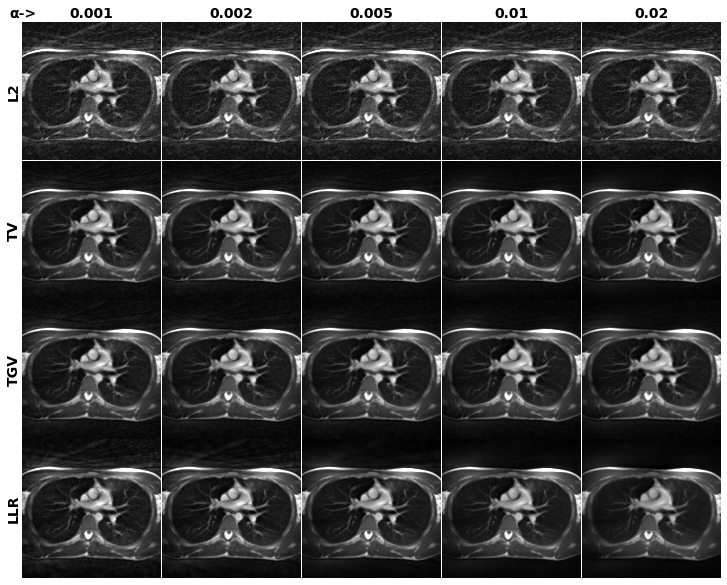

In [21]:
# Plot magnitude images

#alpha = [0.00001,0.0001,0.001,0.01,0.1]
alpha = [0.001,0.002,0.005,0.01,0.02]

plot_index = 17

plt.close('all')

f, a = plt.subplots(4, len(alpha), figsize=(10, 8))

lim = np.percentile(np.abs(L2_ref['diff'])[:,:,plot_index,0],99)

for alp ,idx in zip(alpha, range(len(alpha))):
    
    ind_L2 = np.where(np.asarray(L2_params) == alp)[0][0]
    ind_TV = np.where(np.asarray(TV_params) == alp)[0][0]
    ind_TGV = np.where(np.asarray(TGV_params) == alp)[0][0]
    ind_LLR = np.where(np.asarray(LLR_params) == alp)[0][0]
    
    
    d_L2 = np.abs(L2_data[ind_L2]['diff'][:,:,plot_index,0])
    d_TV = np.abs(TV_data[ind_TV]['diff'][:,:,plot_index,0])
    d_TGV = np.abs(TGV_data[ind_TGV]['diff'][:,:,plot_index,0])
    d_LLR = np.abs(LLR_data[ind_LLR]['diff'][:,:,plot_index,0])
    
    a[0,idx].imshow(d_L2,cmap = 'gray',vmin=0,vmax=lim)
    a[1,idx].imshow(d_TV,cmap = 'gray',vmin=0,vmax=lim)
    a[2,idx].imshow(d_TGV,cmap = 'gray',vmin=0,vmax=lim)
    a[3,idx].imshow(d_LLR,cmap = 'gray',vmin=0,vmax=lim)

[_.axis("off") for _ in a.flatten()];

a[0,0].text(-2,a[0,0].dataLim.get_points()[1][1]/2,'L2',rotation='vertical', verticalalignment='center',horizontalalignment='right',fontweight='semibold',fontsize=14);
a[1,0].text(-2,a[1,0].dataLim.get_points()[1][1]/2,'TV',rotation='vertical', verticalalignment='center',horizontalalignment='right',fontweight='semibold',fontsize=14);
a[2,0].text(-2,a[2,0].dataLim.get_points()[1][1]/2,'TGV',rotation='vertical', verticalalignment='center',horizontalalignment='right',fontweight='semibold',fontsize=14);
a[3,0].text(-2,a[3,0].dataLim.get_points()[1][1]/2,'LLR',rotation='vertical', verticalalignment='center',horizontalalignment='right',fontweight='semibold',fontsize=14);

a[0,0].text(0,-2,'α->',rotation='horizontal', verticalalignment='bottom',horizontalalignment='center',fontweight='semibold',fontsize=14);

a[0,0].text(a[0,0].dataLim.get_points()[1][0]/2,-2,'0.001',rotation='horizontal', verticalalignment='bottom',horizontalalignment='center',fontweight='semibold',fontsize=14);
a[0,1].text(a[0,1].dataLim.get_points()[1][0]/2,-2,'0.002',rotation='horizontal', verticalalignment='bottom',horizontalalignment='center',fontweight='semibold',fontsize=14);
a[0,2].text(a[0,2].dataLim.get_points()[1][0]/2,-2,'0.005',rotation='horizontal', verticalalignment='bottom',horizontalalignment='center',fontweight='semibold',fontsize=14);
a[0,3].text(a[0,3].dataLim.get_points()[1][0]/2,-2,'0.01',rotation='horizontal', verticalalignment='bottom',horizontalalignment='center',fontweight='semibold',fontsize=14);
a[0,4].text(a[0,4].dataLim.get_points()[1][0]/2,-2,'0.02',rotation='horizontal', verticalalignment='bottom',horizontalalignment='center',fontweight='semibold',fontsize=14);

plt.subplots_adjust(left=0.025,right=0.995,top=0.97,bottom=0.005,wspace=0.005,hspace=0.005)


# f, a = plt.subplots(4, len(alpha), figsize=(10, 8))

# for alp ,idx in zip(alpha, range(len(alpha))):
    
#     ind_L2 = np.where(np.asarray(L2_params) == alp)[0][0]
#     ind_TV = np.where(np.asarray(TV_params) == alp)[0][0]
#     ind_TGV = np.where(np.asarray(TGV_params) == alp)[0][0]
#     ind_LLR = np.where(np.asarray(LLR_params) == alp)[0][0]
    
    
#     d_L2 = np.abs(L2_data[ind_L2]['diff'][:,:,plot_index,0])[40:120,50:130]
#     d_TV = np.abs(TV_data[ind_TV]['diff'][:,:,plot_index,0])[40:120,50:130]
#     d_TGV = np.abs(TGV_data[ind_TGV]['diff'][:,:,plot_index,0])[40:120,50:130]
#     d_LLR = np.abs(LLR_data[ind_LLR]['diff'][:,:,plot_index,0])[40:120,50:130]
    
#     a[0,idx].imshow(d_L2,cmap = 'gray',vmin=0,vmax=lim)
#     a[1,idx].imshow(d_TV,cmap = 'gray',vmin=0,vmax=lim)
#     a[2,idx].imshow(d_TGV,cmap = 'gray',vmin=0,vmax=lim)
#     a[3,idx].imshow(d_LLR,cmap = 'gray',vmin=0,vmax=lim)


# [_.axis("off") for _ in a.flatten()];
# plt.subplots_adjust(left=0.005,right=0.995,top=0.995,bottom=0.005,wspace=0.005,hspace=0.005)

# f, a = plt.subplots(4, len(alpha), figsize=(10, 8))

# for alp ,idx in zip(alpha, range(len(alpha))):
    
#     ind_L2 = np.where(np.asarray(L2_params) == alp)[0][0]
#     ind_TV = np.where(np.asarray(TV_params) == alp)[0][0]
#     ind_TGV = np.where(np.asarray(TGV_params) == alp)[0][0]
#     ind_LLR = np.where(np.asarray(LLR_params) == alp)[0][0]
    
    
#     d_L2 = np.angle(L2_data[ind_L2]['diff'][:,:,plot_index,0])[55:105,70:120]
#     d_TV = np.angle(TV_data[ind_TV]['diff'][:,:,plot_index,0])[55:105,70:120]
#     d_TGV = np.angle(TGV_data[ind_TGV]['diff'][:,:,plot_index,0])[55:105,70:120]
#     d_LLR = np.angle(LLR_data[ind_LLR]['diff'][:,:,plot_index,0])[55:105,70:120]
    
#     a[0,idx].imshow(d_L2,cmap = 'bwr',vmin=-np.pi,vmax=np.pi)
#     a[1,idx].imshow(d_TV,cmap = 'bwr',vmin=-np.pi,vmax=np.pi)
#     a[2,idx].imshow(d_TGV,cmap = 'bwr',vmin=-np.pi,vmax=np.pi)
#     a[3,idx].imshow(d_LLR,cmap = 'bwr',vmin=-np.pi,vmax=np.pi)



# [_.axis("off") for _ in a.flatten()];
#plt.subplots_adjust(left=0.005,right=0.995,top=0.995,bottom=0.005,wspace=0.005,hspace=0.005)

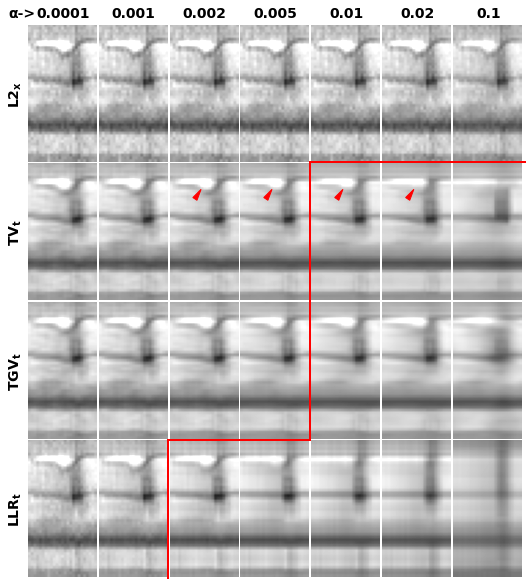

In [22]:
alpha = [0.0001,0.001,0.002,0.005,0.01,0.02, 0.1]

plot_index = 17

slice_ind = 94
slice_width = [55,105]

plt.close('all')

f, a = plt.subplots(4, len(alpha), figsize=(len(alpha)*1.03, 8))

lim = np.percentile(np.abs(L2_ref['diff'])[:,:,plot_index,0],99)

for alp ,idx in zip(alpha, range(len(alpha))):
    
    ind_L2 = np.where(np.asarray(L2_params) == alp)[0][0]
    ind_TV = np.where(np.asarray(TV_params) == alp)[0][0]
    ind_TGV = np.where(np.asarray(TGV_params) == alp)[0][0]
    ind_LLR = np.where(np.asarray(LLR_params) == alp)[0][0]
    
    
    d_L2 = np.abs(L2_data[ind_L2]['diff'][slice_width[0]:slice_width[1],slice_ind,:,0])
    d_TV = np.abs(TV_data[ind_TV]['diff'][slice_width[0]:slice_width[1],slice_ind,:,0])
    d_TGV = np.abs(TGV_data[ind_TGV]['diff'][slice_width[0]:slice_width[1],slice_ind,:,0])
    d_LLR = np.abs(LLR_data[ind_LLR]['diff'][slice_width[0]:slice_width[1],slice_ind,:,0])
    
    a[0,idx].imshow(d_L2,cmap = 'gray',vmin=0,vmax=lim)
    a[1,idx].imshow(d_TV,cmap = 'gray',vmin=0,vmax=lim)
    a[2,idx].imshow(d_TGV,cmap = 'gray',vmin=0,vmax=lim)
    a[3,idx].imshow(d_LLR,cmap = 'gray',vmin=0,vmax=lim)

[_.axis("off") for _ in a.flatten()];

a[0,0].text(-2,a[0,0].dataLim.get_points()[1][1]/2,'$\mathregular{L2_{x}}$',rotation='vertical', verticalalignment='center',horizontalalignment='right',fontweight='bold',fontsize=14);
a[1,0].text(-2,a[1,0].dataLim.get_points()[1][1]/2,'$\mathregular{TV_{t}}$',rotation='vertical', verticalalignment='center',horizontalalignment='right',fontweight='semibold',fontsize=14);
a[2,0].text(-2,a[2,0].dataLim.get_points()[1][1]/2,'$\mathregular{TGV_{t}}$',rotation='vertical', verticalalignment='center',horizontalalignment='right',fontweight='semibold',fontsize=14);
a[3,0].text(-2,a[3,0].dataLim.get_points()[1][1]/2,'$\mathregular{LLR_{t}}$',rotation='vertical', verticalalignment='center',horizontalalignment='right',fontweight='semibold',fontsize=14);

a[0,0].text(-a[0,0].dataLim.get_points()[1][0]/10,-2,'α->',rotation='horizontal', verticalalignment='bottom',horizontalalignment='center',fontweight='semibold',fontsize=14);

for a_idx in range(len(alpha)):

    a[0,a_idx].text(a[0,a_idx].dataLim.get_points()[1][0]/2,-2,str(alpha[a_idx]),rotation='horizontal', verticalalignment='bottom',horizontalalignment='center',fontweight='semibold',fontsize=14);

plt.subplots_adjust(left=0.04,right=0.995,top=0.96,bottom=0.001,wspace=0.01,hspace=0.01)

f.add_artist(lines.Line2D([0.312, 0.312], [0, 0.24],color='r',linewidth=2))
f.add_artist(lines.Line2D([0.312, 0.585], [0.24, 0.24],color='r',linewidth=2))
f.add_artist(lines.Line2D([0.585, 0.585], [0.24, 0.722],color='r',linewidth=2))
f.add_artist(lines.Line2D([0.585, 1], [0.722, 0.722],color='r',linewidth=2))

p1 = np.array([11,9])
pol1 = plt.Polygon(np.array([p1,p1-np.array([3,-3]),p1-np.array([1.5,-4])]),color='r')
a[1,2].add_patch(pol1)
pol1 = plt.Polygon(np.array([p1,p1-np.array([3,-3]),p1-np.array([1.5,-4])]),color='r')
a[1,3].add_patch(pol1)
pol1 = plt.Polygon(np.array([p1,p1-np.array([3,-3]),p1-np.array([1.5,-4])]),color='r')
a[1,4].add_patch(pol1)
pol1 = plt.Polygon(np.array([p1,p1-np.array([3,-3]),p1-np.array([1.5,-4])]),color='r')
a[1,5].add_patch(pol1)

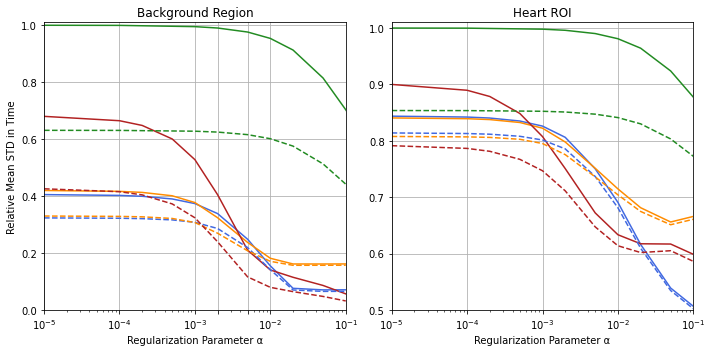

In [23]:
TV_mag_std_data = np.asarray(mag_std_TV)
TGV_mag_std_data = np.asarray(mag_std_TGV)
LLR_mag_std_data = np.asarray(mag_std_LLR)
L2_mag_std_data = np.asarray(mag_std_L2)

TV_mag_median_std_data = np.asarray(mag_median_std_TV)
TGV_mag_median_std_data = np.asarray(mag_median_std_TGV)
LLR_mag_median_std_data = np.asarray(mag_median_std_LLR)
L2_mag_median_std_data = np.asarray(mag_median_std_L2)


plt.close('all')
f, a = plt.subplots(1, len(std_probe_indices), figsize=(10, 5))

for a_idx in range(len(std_probe_indices)):
    if isinstance(a, np.ndarray):
        a[a_idx].semilogx(L2_params,L2_mag_std_data[:,a_idx]/mag_std_L2_ref[a_idx],c=colors[2])
        a[a_idx].semilogx(TV_params,TV_mag_std_data[:,a_idx]/mag_std_L2_ref[a_idx],c=colors[0])
        a[a_idx].semilogx(TGV_params,TGV_mag_std_data[:,a_idx]/mag_std_L2_ref[a_idx],c=colors[1])        
        a[a_idx].semilogx(LLR_params,LLR_mag_std_data[:,a_idx]/mag_std_L2_ref[a_idx],c=colors[3])
        
        a[a_idx].semilogx(L2_params,L2_mag_median_std_data[:,a_idx]/mag_std_L2_ref[a_idx],c=colors[2],linestyle='--')
        a[a_idx].semilogx(TV_params,TV_mag_median_std_data[:,a_idx]/mag_std_L2_ref[a_idx],c=colors[0],linestyle='--')
        a[a_idx].semilogx(TGV_params,TGV_mag_median_std_data[:,a_idx]/mag_std_L2_ref[a_idx],c=colors[1],linestyle='--')
        a[a_idx].semilogx(LLR_params,LLR_mag_median_std_data[:,a_idx]/mag_std_L2_ref[a_idx],c=colors[3],linestyle='--')

        
    else:
        a.semilogx(L2_params,L2_mag_std_data/mag_std_L2_ref[a_idx])
        a.semilogx(TV_params,TV_mag_std_data/mag_std_L2_ref[a_idx])
        a.semilogx(TGV_params,TGV_mag_std_data/mag_std_L2_ref[a_idx])
        a.semilogx(LLR_params,LLR_mag_std_data/mag_std_L2_ref[a_idx])
       
custom_lines = [lines.Line2D([0], [0], color=colors[2], lw=1),
                lines.Line2D([0], [0], color=colors[0], lw=1),
                lines.Line2D([0], [0], color=colors[1], lw=1),
                lines.Line2D([0], [0], color=colors[3], lw=1),
                lines.Line2D([0], [0], color=[0.4,0.4,0.4], lw=1, linestyle='--')]        
#a[0].legend(custom_lines,['$\mathregular{L2_x}$','$\mathregular{TV_t}$','$\mathregular{TGV_t}$','$\mathregular{LLR_t}$','$\mathregular{+ Median_t}$'],loc=1)



a[0].set_ylim([0,1.01])
a[1].set_ylim([0.5,1.01])

a[0].set_xlim([1e-5,1e-1])
a[1].set_xlim([1e-5,1e-1])

a[0].set_xticks([1e-5,1e-4,1e-3,2e-3,5e-3,1e-2,1e-1])
a[1].set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1])

a[0].set_ylabel('Relative Mean STD in Time')

a[0].set_xlabel('Regularization Parameter α')
a[1].set_xlabel('Regularization Parameter α')

a[0].set_title('Background Region')
a[1].set_title('Heart ROI')


#a[1].set_yticklabels([])

a[0].grid()
a[1].grid()

f.tight_layout()

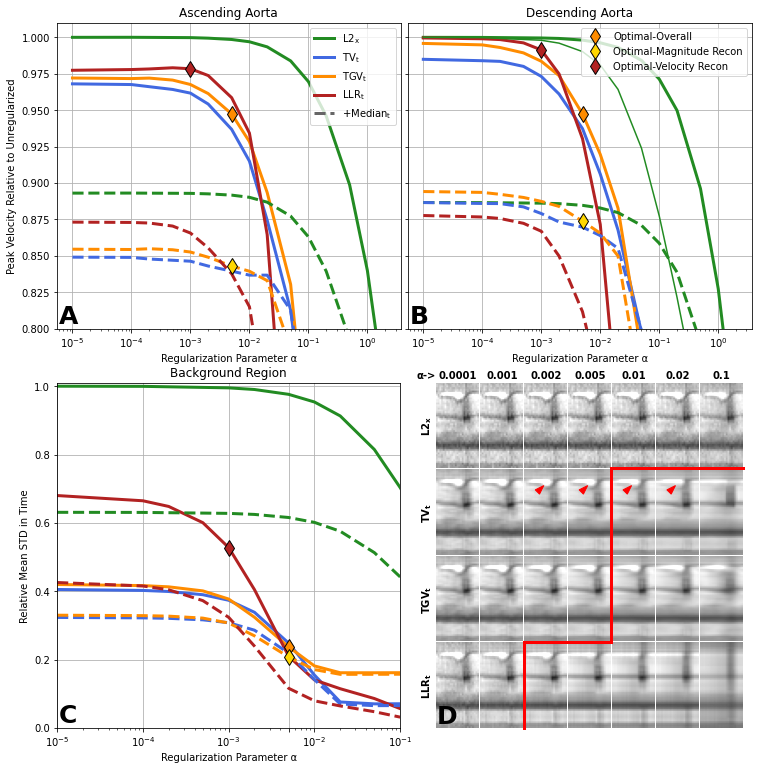

In [24]:
# plt.close('all')

lw = 3

fig = plt.figure(figsize=(10, 10),constrained_layout=False)

top,bottom= fig.subfigures(nrows=2, ncols=1)

ax_top = top.subplots(1,2)

a_idx=0
ax_top[0].semilogx(L2_params,L2_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[2],lw=lw)
ax_top[0].semilogx(TV_params,TV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[0],lw=lw)
ax_top[0].semilogx(TGV_params,TGV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[1],lw=lw)
ax_top[0].semilogx(LLR_params,LLR_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[3],lw=lw)

ax_top[0].semilogx(L2_params,L2_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[2],linestyle='--',lw=lw)
ax_top[0].semilogx(TV_params,TV_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[0],linestyle='--',lw=lw)
ax_top[0].semilogx(TGV_params,TGV_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[1],linestyle='--',lw=lw)
ax_top[0].semilogx(LLR_params,LLR_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[3],linestyle='--',lw=lw)

a_idx=1
ax_top[1].semilogx(L2_params,L2_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[2],lw=lw)
ax_top[1].semilogx(TV_params,TV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[0],lw=lw)
ax_top[1].semilogx(TGV_params,TGV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[1],lw=lw)
ax_top[1].semilogx(LLR_params,LLR_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[3],lw=lw)

ax_top[1].semilogx(L2_params,L2_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[2],linestyle='--',lw=lw)
ax_top[1].semilogx(TV_params,TV_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[0],linestyle='--',lw=lw)
ax_top[1].semilogx(TGV_params,TGV_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[1],linestyle='--',lw=lw)
ax_top[1].semilogx(LLR_params,LLR_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[3],linestyle='--',lw=lw)

ax_top[1].semilogx(L2_params,L2_mag_std_data[:,1]/mag_std_L2_ref[a_idx],c=colors[2])


custom_lines = [lines.Line2D([0], [0], color=colors[2], lw=lw),
                lines.Line2D([0], [0], color=colors[0], lw=lw),
                lines.Line2D([0], [0], color=colors[1], lw=lw),
                lines.Line2D([0], [0], color=colors[3], lw=lw),
                lines.Line2D([0], [0], color=[0.4,0.4,0.4], lw=lw, linestyle='--')]        
ax_top[0].legend(custom_lines,['$\mathregular{L2_x}$','$\mathregular{TV_t}$','$\mathregular{TGV_t}$','$\mathregular{LLR_t}$','$\mathregular{+ Median_t}$'],loc=1)

ax_top[0].set_ylim([0.8,1.01])
ax_top[1].set_ylim([0.8,1.01])

ax_top[0].set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])
ax_top[1].set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])

ax_top[0].set_ylabel('Peak Velocity Relative to Unregularized')

ax_top[0].set_xlabel('Regularization Parameter α')
ax_top[1].set_xlabel('Regularization Parameter α')

ax_top[0].set_title('Ascending Aorta')
ax_top[1].set_title('Descending Aorta')

ax_top[1].set_yticklabels([])

ax_top[0].grid()
ax_top[1].grid()

top.subplots_adjust(left=0.03,right=0.995,top=0.96,bottom=0.11,wspace=0.02,hspace=0.01)

ax_top[0].text(6e-6,0.8,'A',rotation='horizontal', verticalalignment='bottom',horizontalalignment='left',fontweight='semibold',fontsize=25,c = 'k');
ax_top[1].text(6e-6,0.8,'B',rotation='horizontal', verticalalignment='bottom',horizontalalignment='left',fontweight='semibold',fontsize=25,c = 'k');


mstyle = 'd'
msize=12

mcolors = ['darkorange','gold','firebrick']

ind_p1 = 6
ax_top[0].plot(TGV_params[ind_p1], TGV_mean_data[ind_p1,0,peak_index[0]]/mean_L2_ref[0][peak_index[0]],mstyle,color = mcolors[0],markersize=msize,markeredgecolor='k')
ax_top[1].plot(TGV_params[ind_p1], TGV_mean_data[ind_p1,1,peak_index[1]]/mean_L2_ref[1][peak_index[1]],mstyle,color = mcolors[0],markersize=msize,markeredgecolor='k')

ind_p2 = 6
ax_top[0].plot(TGV_params[ind_p2], TGV_median_mean_data[ind_p2,0,peak_index[0]]/mean_L2_ref[0][peak_index[0]],mstyle,color = mcolors[1],markersize=msize,markeredgecolor='k')
ax_top[1].plot(TGV_params[ind_p2], TGV_median_mean_data[ind_p2,1,peak_index[1]]/mean_L2_ref[1][peak_index[1]],mstyle,color = mcolors[1],markersize=msize,markeredgecolor='k')

ind_p3 = 4
ax_top[0].plot(LLR_params[ind_p3], LLR_mean_data[ind_p3,0,peak_index[0]]/mean_L2_ref[0][peak_index[0]],mstyle,color = mcolors[2],markersize=msize,markeredgecolor='k')
ax_top[1].plot(LLR_params[ind_p3], LLR_mean_data[ind_p3,1,peak_index[1]]/mean_L2_ref[1][peak_index[1]],mstyle,color = mcolors[2],markersize=msize,markeredgecolor='k')

custom_markers = [lines.Line2D([0], [0], color=mcolors[0], lw=lw, linestyle = 'None', marker= 'd',markersize=msize,markeredgecolor='k'),
                  lines.Line2D([0], [0], color=mcolors[1], lw=lw, linestyle = 'None', marker= 'd',markersize=msize,markeredgecolor='k'),
                  lines.Line2D([0], [0], color=mcolors[2], lw=lw, linestyle = 'None', marker= 'd',markersize=msize,markeredgecolor='k')]
ax_top[1].legend(custom_markers, ['Optimal-Overall','Optimal-Magnitude Recon','Optimal-Velocity Recon'],loc=1)

# Bottom Plots

left,right = bottom.subfigures(nrows=1,ncols=2,width_ratios=[1.03,1])

# Bottom Left
ax_left = left.subplots(1,1)

ax_left.semilogx(L2_params,L2_mag_std_data[:,0]/mag_std_L2_ref[0],c=colors[2],lw=lw)
ax_left.semilogx(TV_params,TV_mag_std_data[:,0]/mag_std_L2_ref[0],c=colors[0],lw=lw)
ax_left.semilogx(TGV_params,TGV_mag_std_data[:,0]/mag_std_L2_ref[0],c=colors[1],lw=lw)        
ax_left.semilogx(LLR_params,LLR_mag_std_data[:,0]/mag_std_L2_ref[0],c=colors[3],lw=lw)

ax_left.semilogx(L2_params,L2_mag_median_std_data[:,0]/mag_std_L2_ref[0],c=colors[2],linestyle='--',lw=lw)
ax_left.semilogx(TV_params,TV_mag_median_std_data[:,0]/mag_std_L2_ref[0],c=colors[0],linestyle='--',lw=lw)
ax_left.semilogx(TGV_params,TGV_mag_median_std_data[:,0]/mag_std_L2_ref[0],c=colors[1],linestyle='--',lw=lw)
ax_left.semilogx(LLR_params,LLR_mag_median_std_data[:,0]/mag_std_L2_ref[0],c=colors[3],linestyle='--',lw=lw)

ax_left.set_ylim([0,1.01])
ax_left.set_xlim([1e-5,1e-1])
ax_left.set_xticks([1e-5,1e-4,1e-3,5e-3,1e-2,1e-1])

ax_left.plot(TGV_params[ind_p1], TGV_mag_std_data[ind_p1,0]/mag_std_L2_ref[0],mstyle,color = mcolors[0],markersize=msize,markeredgecolor='k')
ax_left.plot(TGV_params[ind_p2], TGV_mag_median_std_data[ind_p2,0]/mag_std_L2_ref[0],mstyle,color = mcolors[1],markersize=msize,markeredgecolor='k')
ax_left.plot(LLR_params[ind_p3], LLR_mag_std_data[ind_p3,0]/mag_std_L2_ref[0],mstyle,color = mcolors[2],markersize=msize,markeredgecolor='k')

ax_left.set_ylabel('Relative Mean STD in Time')

ax_left.set_xlabel('Regularization Parameter α')

ax_left.set_title('Background Region')

ax_left.grid()

ax_left.text(1.05e-5,0,'C',rotation='horizontal', verticalalignment='bottom',horizontalalignment='left',fontweight='semibold',fontsize=25,c = 'k');

left.subplots_adjust(left=0.06,right=0.999,top=0.96,bottom=0.001,wspace=0,hspace=0.01)

#Bottom Right

alpha = [0.0001,0.001,0.002,0.005,0.01,0.02, 0.1]

plot_index = 17

slice_ind = 94
slice_width = [55,105]

a = right.subplots(4, len(alpha))

lim = np.percentile(np.abs(L2_ref['diff'])[:,:,plot_index,0],99)

for alp ,idx in zip(alpha, range(len(alpha))):
    
    ind_L2 = np.where(np.asarray(L2_params) == alp)[0][0]
    ind_TV = np.where(np.asarray(TV_params) == alp)[0][0]
    ind_TGV = np.where(np.asarray(TGV_params) == alp)[0][0]
    ind_LLR = np.where(np.asarray(LLR_params) == alp)[0][0]
    
    
    d_L2 = np.abs(L2_data[ind_L2]['diff'][slice_width[0]:slice_width[1],slice_ind,:,0])
    d_TV = np.abs(TV_data[ind_TV]['diff'][slice_width[0]:slice_width[1],slice_ind,:,0])
    d_TGV = np.abs(TGV_data[ind_TGV]['diff'][slice_width[0]:slice_width[1],slice_ind,:,0])
    d_LLR = np.abs(LLR_data[ind_LLR]['diff'][slice_width[0]:slice_width[1],slice_ind,:,0])
    
    a[0,idx].imshow(d_L2,cmap = 'gray',vmin=0,vmax=lim)
    a[1,idx].imshow(d_TV,cmap = 'gray',vmin=0,vmax=lim)
    a[2,idx].imshow(d_TGV,cmap = 'gray',vmin=0,vmax=lim)
    a[3,idx].imshow(d_LLR,cmap = 'gray',vmin=0,vmax=lim)

[_.axis("off") for _ in a.flatten()];

label_font= 10

a[0,0].text(-2,a[0,0].dataLim.get_points()[1][1]/2,'$\mathregular{L2_{x}}$',rotation='vertical', verticalalignment='center',horizontalalignment='right',fontweight='bold',fontsize=label_font);
a[1,0].text(-2,a[1,0].dataLim.get_points()[1][1]/2,'$\mathregular{TV_{t}}$',rotation='vertical', verticalalignment='center',horizontalalignment='right',fontweight='semibold',fontsize=label_font);
a[2,0].text(-2,a[2,0].dataLim.get_points()[1][1]/2,'$\mathregular{TGV_{t}}$',rotation='vertical', verticalalignment='center',horizontalalignment='right',fontweight='semibold',fontsize=label_font);
a[3,0].text(-2,a[3,0].dataLim.get_points()[1][1]/2,'$\mathregular{LLR_{t}}$',rotation='vertical', verticalalignment='center',horizontalalignment='right',fontweight='semibold',fontsize=label_font);

a[0,0].text(-1,-2,'α->',rotation='horizontal', verticalalignment='bottom',horizontalalignment='right',fontweight='semibold',fontsize=label_font);

for a_idx in range(len(alpha)):

    a[0,a_idx].text(a[0,a_idx].dataLim.get_points()[1][0]/2,-2,str(alpha[a_idx]),rotation='horizontal', verticalalignment='bottom',horizontalalignment='center',fontweight='semibold',fontsize=label_font);

right.subplots_adjust(left=0.1,right=0.965,top=0.96,bottom=0.001,wspace=0.01,hspace=0.01)

linew = 3
right.add_artist(lines.Line2D([0.348, 0.348], [0, 0.24],color='r',linewidth=linew))
right.add_artist(lines.Line2D([0.348, 0.593], [0.24, 0.24],color='r',linewidth=linew))
right.add_artist(lines.Line2D([0.593, 0.593], [0.24, 0.722],color='r',linewidth=linew))
right.add_artist(lines.Line2D([0.593, 0.965], [0.722, 0.722],color='r',linewidth=linew))

p1 = np.array([11,9])
pol1 = plt.Polygon(np.array([p1,p1-np.array([5,-2.5]),p1-np.array([2.5,-5])]),color='r')
a[1,2].add_patch(pol1)
pol1 = plt.Polygon(np.array([p1,p1-np.array([5,-2.5]),p1-np.array([2.5,-5])]),color='r')
a[1,3].add_patch(pol1)
pol1 = plt.Polygon(np.array([p1,p1-np.array([5,-2.5]),p1-np.array([2.5,-5])]),color='r')
a[1,4].add_patch(pol1)
pol1 = plt.Polygon(np.array([p1,p1-np.array([5,-2.5]),p1-np.array([2.5,-5])]),color='r')
a[1,5].add_patch(pol1)

a[3,0].text(0,50,'D',rotation='horizontal', verticalalignment='bottom',horizontalalignment='left',fontweight='semibold',fontsize=25,c = 'k');

#plt.savefig(figure_folder+'V2_Figure3.png',dpi=1000,bbox_inches='tight')
plt.savefig('Figure_TIFF/Figure 4.tiff',dpi=180,bbox_inches='tight',facecolor='white')

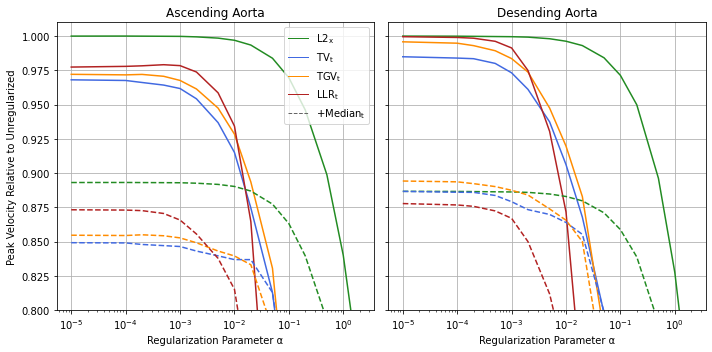

In [25]:
peak_index = [17,18,19]

colors = ['royalblue','darkorange','forestgreen','firebrick']

TV_mean_data = np.asarray(TV_mean_list)
TV_median_mean_data = np.asarray(TV_median_mean_list)
TV_std_data = np.asarray(TV_std_list)

TGV_mean_data = np.asarray(TGV_mean_list)
TGV_median_mean_data = np.asarray(TGV_median_mean_list)
TGV_std_data = np.asarray(TGV_std_list)

LLR_mean_data = np.asarray(LLR_mean_list)
LLR_median_mean_data = np.asarray(LLR_median_mean_list)
LLR_std_data = np.asarray(LLR_std_list)

L2_mean_data = np.asarray(L2_mean_list)
L2_median_mean_data = np.asarray(L2_median_mean_list)
L2_std_data = np.asarray(L2_std_list)

plt.close('all')
f, a = plt.subplots(1, len(probe_indices), figsize=(10, 5))

for a_idx in range(len(probe_indices)):
    if isinstance(a, np.ndarray):
        a[a_idx].semilogx(L2_params,L2_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[2])
        a[a_idx].semilogx(TV_params,TV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[0])
        a[a_idx].semilogx(TGV_params,TGV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[1])
        a[a_idx].semilogx(LLR_params,LLR_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[3])
        
        a[a_idx].semilogx(L2_params,L2_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[2],linestyle='--')
        a[a_idx].semilogx(TV_params,TV_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[0],linestyle='--')
        a[a_idx].semilogx(TGV_params,TGV_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[1],linestyle='--')
        a[a_idx].semilogx(LLR_params,LLR_median_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]],c=colors[3],linestyle='--')
    else:
        a.semilogx(L2_params,L2_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]])
        a.semilogx(TV_params,TV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]])
        a.semilogx(TGV_params,TGV_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]])
        a.semilogx(LLR_params,LLR_mean_data[:,a_idx,peak_index[a_idx]]/mean_L2_ref[a_idx][peak_index[a_idx]])
        

custom_lines = [lines.Line2D([0], [0], color=colors[2], lw=1),
                lines.Line2D([0], [0], color=colors[0], lw=1),
                lines.Line2D([0], [0], color=colors[1], lw=1),
                lines.Line2D([0], [0], color=colors[3], lw=1),
                lines.Line2D([0], [0], color=[0.4,0.4,0.4], lw=1, linestyle='--')]        
a[0].legend(custom_lines,['$\mathregular{L2_x}$','$\mathregular{TV_t}$','$\mathregular{TGV_t}$','$\mathregular{LLR_t}$','$\mathregular{+ Median_t}$'],loc=1)

a[0].set_ylim([0.8,1.01])
a[1].set_ylim([0.8,1.01])

a[0].set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])
a[1].set_xticks([1e-5,1e-4,1e-3,1e-2,1e-1,1])

a[0].set_ylabel('Peak Velocity Relative to Unregularized')

a[0].set_xlabel('Regularization Parameter α')
a[1].set_xlabel('Regularization Parameter α')

a[0].set_title('Ascending Aorta')
a[1].set_title('Desending Aorta')

a[1].set_yticklabels([])

a[0].grid()
a[1].grid()

f.tight_layout()